In [7]:
#imports
import json
from pprint import pprint
import scipy.optimize as optimize
import pandas as pd
import numpy as np
from datetime import datetime
from enum import Enum
import sys
import timeit
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from dateutil import tz
import gzip
from pathlib import Path
# import L4.L4 as L4

# from pandas.plotting import parallel_coordinates
# from sklearn.mixture import GaussianMixture as GMM
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import KMeans
plt.style.use('seaborn')

In [8]:
#we need to preprocess the data
def getBookContract(aStringNumberContract, aTypeOption):
    aContract = ''
    if aStringNumberContract == "000" and aTypeOption == "1":
        aContract = CONTRACTTYPE.FUTURE #replace with enums
    elif aTypeOption == "2":
        aContract = CONTRACTTYPE.CALL 
    elif aTypeOption == "3":
        aContract = CONTRACTTYPE.PUT 
    else:
        print("error, Contract Type" + str(aStringNumberContract) + " , " + str(aTypeOption) + " not recognized")
    
    return aContract

class CONTRACTTYPE(Enum):
    UNSET = 0
    FUTURE = 1
    CALL = 2
    PUT = 3

In [9]:

def getExpiryDate(aBook):
    anExpiryCode  = aBook[6:8]
    #hardcoded version for now. 
    myString_date = ''
    
    myString_year = ''
    myString_month = ''
    myString_day = ''
    
    #get year code
    if anExpiryCode[0] == 'L':
        myString_year = "2016"
    elif anExpiryCode[0] == 'M':
        myString_year = "2017"
    elif anExpiryCode[0] == 'N':
        myString_year = "2018"
    elif anExpiryCode[0] == 'P': #It looks strange, but that's KRX 
        myString_year = "2019"
    else : 
        sys.stderr.write("fatal error\n expiry year code unknown \n")
    
    #get month code
    myPotentialMonths = ['','1','2','3','4','5','6','7','8','9','A','B','C']

    if anExpiryCode[1] in myPotentialMonths:
        myString_month =  str(myPotentialMonths.index(anExpiryCode[1]))
    else : 
        sys.stderr.write("fatal error\n expiry month code unknown \n")    
    
    if myString_month == '':
        sys.stderr.write("fatal error\n expiry month code unknown \n")   
    #get day
    #get third Wednesday of every month, we will have to make bank holidays exceptions
    myString_day = str(calendar.Calendar(2).monthdatescalendar(int(myString_year), \
                                                               int(myString_month))[3][0].day)
    
#     print(myString_month)                   
    myString_date = myString_year+'-'+myString_month+'-'+myString_day+' 16:00:00'

    timeZone = tz.gettz('Asia/Seoul')
            
    #print("Don't forget bank holidays exceptions")
    return datetime.strptime(myString_date, "%Y-%m-%d %H:%M:%S").replace(tzinfo=timeZone).astimezone(timeZone)


In [10]:
#get the right time for plotting later
def utcToRightTMZ(aUTCTMZ):
    
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('Asia/Seoul')
    
    aUTCTMZ = aUTCTMZ.replace(tzinfo=from_zone)
    localTimeStamp = aUTCTMZ.astimezone(to_zone)
    
    return localTimeStamp

# Load Data

In [11]:
def inStrikeRange(aFutBook, aOptBook):
    '''
    look at slightly OTM or ITM options and keep that range static. Change dynamically book to keep that range
    '''
    if aFutBook == '' or aOptBook == '': #if the fut book is not itialized
        return False
    elif getBookContract(aOptBook[8:11],aOptBook[3]) is not CONTRACTTYPE.CALL : #only if Call
        return False
    
    return ((int(aOptBook[8:11]) > int(5 * np.floor((aFutBook['bid_price_0']+ aFutBook['ask_price_0'])/2/5))-5 )
    and (int(aOptBook[8:11]) < int(5 * np.ceil((aFutBook['bid_price_0']+ aFutBook['ask_price_0'])/2/5))+11))

def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    '''
    aOptionStrike: enables to initialize the book to start with
    '''
    myTicksOfInterest = np.empty(shape = (0,0))
    myCounter = 0
    myLastVol = 0
    myLastVolFut = 0
    timeOfTradeFut = 0
    myFutPrice = 0
    myDTM = -1 #dayToMaturity
    
    myFirstFut = True
    myFirstOpt = True
    myFutBook = ''
    myOptionBook = ''
    myPastOptionBook = ''
    myTimeList = [] #faster than nparray for appending
    myYTimeList = []
    
    myUpperCounter = -1 #future prediction
    myLowerCounter = 0
    Ys = [] #to predict
    
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            myTickCreatedTime = tick['created']/1000000 #vastly reused in the code
            TTM = (getExpiryDate(myBook) - utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))).total_seconds()/3600/24    
#             test.append(TTM)
#             print(TTM)
            if(getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE) and TTM<60 :

                if tick['type']=='lastdone' : 
#                     print('2')
                    if myFirstFut:
                        myFutBook = myBook
                        myFirstFut = False

                    if myFutBook == myBook:
                        myLastVolFut = (0.995*myLastVol + 0.001*(tick['volume']))
                        timeOfTradeFut = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                        myFutPrice = tick['price']
                else:
                    myFutTick = tick
                    
            if not myFirstFut and inStrikeRange(myFutTick, myBook) and (myDTM==np.floor(TTM) or myDTM==-1) and TTM<30: #this also checks if is CALL
#                 print('3')
                    #we need to go through a first future to calculate the moneyness
                    #range we accept to look at a product (keep it not too small or it will always change book)
                myFutMid = (myFutTick['bid_price_0']+ myFutTick['ask_price_0'])/2
                #check for not initialized book or if not in range book
                if np.isnan(aOptionStrike) or not inStrikeRange(myFutTick, myOptionBook) :
                    aOptionStrike = int(5 * np.ceil(myFutMid/5))
                
                if tick['type']=='lastdone' and myBook[8:11]==str(aOptionStrike):

                    if myFirstOpt:
                        myOptionBook = myBook
                        myFirstOpt = False
                        myDTM = np.floor(TTM)

#                     if myOptionBook == myBook:   
                    myLastVol = (0.995*myLastVol + 0.0007*(tick['volume']))
                    timeOfTrade = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
        
                if tick['type']=='tick'  and myBook[8:11]==str(aOptionStrike):
                    
                    if myFirstOpt:
                        myOptionBook = myBook
                        myFirstOpt = False
                        myPastOptionBook = tick
                        myDTM = np.floor(TTM)
                        
                        myOldTime = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                        myIniSeconds = np.floor(myTickCreatedTime)

                                        #only interested in first 2 levels  
                    
                    if (tick['ask_volume_0'] != myPastOptionBook['ask_volume_0']) or \
                        (tick['ask_volume_1'] != myPastOptionBook['ask_volume_1']) or \
                        (tick['bid_volume_0'] != myPastOptionBook['bid_volume_0']) or \
                        (tick['bid_volume_1'] != myPastOptionBook['bid_volume_1']):
#                         print(aOptionStrike, myFutMid)                    

                        myPastOptionBook = tick
                        
                        
                        currTime = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                            #keep in mind the time second per sec
                        
                        myTimeList.append(myTickCreatedTime-myIniSeconds)
                        myYTimeList.append(myTickCreatedTime-myIniSeconds)
                        myCounter += 1
                        
                        
                        
                        
                        #Using a ring buffer wouldn't work ... so :
                        myC3=0
                        myC1=0
                        myC05=0
                        myC025=0
                        myC01=0
                        myIdxToStartForClean=0
                        for idx,dtStart in enumerate(myTimeList): #I know, could do better
                            dtRecent = myTimeList[-1] - dtStart
                            if dtRecent>=3:
                                myIdxToStartForClean = idx
                            if dtRecent<3:
                                myC3 +=1
                            if dtRecent<1:
                                myC1 +=1   
                            if dtRecent<0.5:
                                myC05 +=1 
                            if dtRecent<0.25:
                                myC025 +=1 
                            if dtRecent<0.1:
                                myC01 +=1
                            if dtRecent<0:
                                print("issue, dt<0")
                                
                        myTimeList = myTimeList[myIdxToStartForClean:] #clean the list
                        
                        

                      
                        
                        try:
     


                            
                            timeOfDay = currTime.hour \
                                        +currTime.minute/60
                                
                            moneyness = 2*myFutMid/int(myOptionBook[8:11])
                            
                            if len(myTicksOfInterest) == 0 :
                                myTicksOfInterest = np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                              15*myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000) , \
                                                              40*myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000),\
                                                             TTM, timeOfDay, moneyness, myC3/15, myC1/10, myC05/5, myC025/2, myC01])
                            else:
                                myTicksOfInterest = np.vstack( (myTicksOfInterest,np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                                        15*myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000), \
                                                               40*myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000),
                                                                        TTM, timeOfDay, moneyness, myC3/15, myC1/10, myC05/5, myC025/2, myC01])) )
                            #for Ys target data:
                            #Using the same list as above, taking the first element and linking to it a nb of tick wouldn't work well because of jumps, some ticks would have no info.
                                                      
                                                                                            
                            myUpperCounter += 1 #we got one element inside the condition, new tick
                        
                            #map from earlier tick
#                             print(myYTimeList)
#                             print(myYTimeList[myLowerCounter])
#                             print(myUpperCounter)
#                             print(myYTimeList[myUpperCounter])
                            while (myYTimeList[myUpperCounter]-myYTimeList[myLowerCounter])>0.4:
                                Ys.append(myUpperCounter-myLowerCounter-1)
                                myLowerCounter += 1                                                                      

                        except Exception as e:
                            print(e)
                            pass #pass, not continue, continue switch to the next itirqtion
                        oldTime = currTime
                    
        if myCounter > nbOfDataPoints_:
            break
    return myTicksOfInterest, Ys

def whichStrikeAtMoney(data_):
    for idx, tick in enumerate(data_):
        myBook = tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 print(tick)
                return int(5 * np.floor((tick['bid_price_0']+ tick['ask_price_0'])/2/5))

In [14]:
#which data we could like and how many points of each :
dataToLoad = ['data\\2017.11.01\\feeddata_10.json.gz',
             'data\\2017.11.02\\feeddata_10.json.gz',
             'data\\2017.10.01\\feeddata_10.json.gz',
             'data\\2017.10.02\\feeddata_10.json.gz']
    


#load the data
train_size = 0.9
#cleaner : keeps the file compressed on the computer
import gc
def loadDataIntoXsYsTestTrain(dataToLoad_):
    for idx,date in enumerate(dataToLoad_):
        with gzip.open(date, "rb") as f:
            data = json.loads(f.read().decode("ascii"))
  
        if idx == 0:
            WaitingTimeAndTrade, target = extractInterestingData(10000,whichStrikeAtMoney(data),data)
            WaitingTimeAndTrade = WaitingTimeAndTrade[1000:len(target)] #we may not have the right number of ticks to make 1s in the end, forget them, and forget the init
            target = np.array(target[1000:]).reshape(len(target[1000:]),1)  
        else :
            WaitingTimeAndTradeTemp, targetTemp = extractInterestingData(10000,whichStrikeAtMoney(data),data)
            #because of the exponential ,oving average, we want to cut the first bit of data out
            WaitingTimeAndTrade=  np.vstack((WaitingTimeAndTrade, WaitingTimeAndTradeTemp[1000:len(targetTemp)])) 
            #we may not have the right number of ticks to make 1s in the end, forget them, and forget the init
            target = np.vstack((target,np.array(targetTemp[1000:]).reshape(len(targetTemp[1000:]),1)))

        print(len(WaitingTimeAndTrade)==len(target))
        
        gc.collect() #clean garbage collector
    return WaitingTimeAndTrade, target

        

In [15]:
WaitingTimeAndTrade, target = loadDataIntoXsYsTestTrain(dataToLoad)

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
True


MemoryError: 

In [1]:

train_size = 0.9

#this is for, if we wanted to condition on time
# train_cnt = int(WaitingTimeAndTrade.shape[0] * train_size)
# x_train = WaitingTimeAndTrade[0:train_cnt]
# y_train = target[0:train_cnt]
# x_test = WaitingTimeAndTrade[train_cnt:]
# y_test = target[train_cnt:]


#normalization : not so important because of batch norm but doesn't create any issue
Xmean = WaitingTimeAndTrade.mean()
Xstd = WaitingTimeAndTrade.std()
WaitingTimeAndTrade = (WaitingTimeAndTrade - Xmean)/Xstd


# # Y Normalization : could speed up training but we loose the simple loss meaning
# Ymean = target.mean()
# Ystd = target.std()
# target = (target - Ymean)/Ystd


#shuffle the array ahead of time:
#unconditional of time:
#we need to shuffle both arrays similarly, let's not use the train/test from sklearn

myIndices = np.arange(len(WaitingTimeAndTrade))
np.random.shuffle(myIndices)
myIndicesForTrain = myIndices[0:int(0.9*len(myIndices))]
myIndicesForTest = myIndices[int(0.9*len(myIndices)):]

x_train = WaitingTimeAndTrade[myIndicesForTrain]
y_train = target[myIndicesForTrain]
x_test = WaitingTimeAndTrade[myIndicesForTest]
y_test = target[myIndicesForTest]

In [14]:
whos

Variable                    Type        Data/Info
-------------------------------------------------
CONTRACTTYPE                EnumMeta    <enum 'CONTRACTTYPE'>
Enum                        EnumMeta    <enum 'Enum'>
Path                        type        <class 'pathlib.Path'>
calendar                    module      <module 'calendar' from '<...>onda3\\lib\\calendar.py'>
dataToLoad                  list        n=4
datetime                    type        <class 'datetime.datetime'>
dt                          module      <module 'datetime' from '<...>onda3\\lib\\datetime.py'>
extractInterestingData      function    <function extractInterest<...>ta at 0x000001353AC26BF8>
getBookContract             function    <function getBookContract at 0x000001353AC26E18>
getExpiryDate               function    <function getExpiryDate at 0x000001352A997488>
gzip                        module      <module 'gzip' from 'C:\\<...>Anaconda3\\lib\\gzip.py'>
inStrikeRange               function    <function

# TF

In [12]:
import tensorflow as tf
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()
tf.reset_default_graph()

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [1]:
# WaitingTimeAndTrade2, target2 = extractInterestingData(10000,whichStrikeAtMoney(data2),data2)
# print(len(target2),len(WaitingTimeAndTrade2))
# #because of the exponential ,oving average, we want to cut the first bit of data out
# WaitingTimeAndTrade2 = WaitingTimeAndTrade2[1000:len(target2)] #we may not have the right number of ticks to make 1s in the end, forget them, and forget the init
# target2 = np.array(target2[1000:]).reshape(len(target2[1000:]),1)
# print(len(target2),len(WaitingTimeAndTrade2))


In [2]:
# WaitingTimeAndTrade = np.vstack((WaitingTimeAndTrade, WaitingTimeAndTrade2))
# target = np.vstack((target, target2))

# del WaitingTimeAndTrade2
# del target2

In [3]:
# print(WaitingTimeAndTrade[3000][-4],target[3000])

In [4]:
# print(len(target2),len(WaitingTimeAndTrade2))

In [5]:
# print(len(target),len(WaitingTimeAndTrade))

In [6]:
# print(sys.getsizeof(data)+sys.getsizeof(data2))
# del data
# del data2

In [7]:
plt.figure(figsize=(20,7))
plt.title('Training Data for TensorFlow')
plt.plot(WaitingTimeAndTrade)
plt.legend(['log(WaitingTime)','Traded volume on Option','Traded Volume on Future','TTM', 'timeOfDay', 'moneyness', 'myC3', 'myC1', 'myC05', 'myC025', 'myC01'])
plt.xlabel('tick count')
plt.show()

NameError: name 'WaitingTimeAndTrade' is not defined

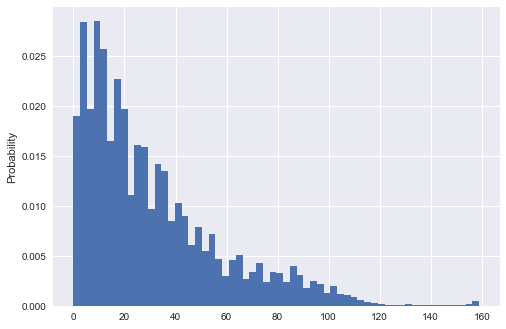

In [13]:
plt.hist(target, normed=True, bins=60)
plt.ylabel('Probability')
plt.show()

In [14]:
tf.reset_default_graph()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75, allow_growth = True)

In [15]:
train_size = 0.9


#this is for, if we wanted to condition on time
# train_cnt = int(WaitingTimeAndTrade.shape[0] * train_size)
# x_train = WaitingTimeAndTrade[0:train_cnt]
# y_train = target[0:train_cnt]
# x_test = WaitingTimeAndTrade[train_cnt:]
# y_test = target[train_cnt:]


#normalization : not so important because of batch norm but doesn't create any issue
Xmean = WaitingTimeAndTrade.mean()
Xstd = WaitingTimeAndTrade.std()
WaitingTimeAndTrade = (WaitingTimeAndTrade - Xmean)/Xstd


# # Y Normalization : could speed up training but we loose the simple loss meaning
# Ymean = target.mean()
# Ystd = target.std()
# target = (target - Ymean)/Ystd


#shuffle the array ahead of time:
#unconditional of time:
#we need to shuffle both arrays similarly, let's not use the train/test from sklearn

myIndices = np.arange(len(WaitingTimeAndTrade))
np.random.shuffle(myIndices)
myIndicesForTrain = myIndices[0:int(0.9*len(myIndices))]
myIndicesForTest = myIndices[int(0.9*len(myIndices)):]

x_train = WaitingTimeAndTrade[myIndicesForTrain]
y_train = target[myIndicesForTrain]
x_test = WaitingTimeAndTrade[myIndicesForTest]
y_test = target[myIndicesForTest]

In [16]:
#clean objects:
del WaitingTimeAndTrade
del target

In [52]:
# Small epsilon value for the BN transform
epsilon = 1e-3
decay = 0.98
n_hidden_1 = 100
n_hidden_2 = 50
n_input = x_train.shape[1]

training_epochs = 50000
display_step = 1000
batch_size = 3000


def batch_norm_wrapper(inputs, n_layer , is_training):

    if is_training:
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        train_mean = tf.assign(pop_mean[n_layer] ,
                               pop_mean[n_layer] * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var[n_layer] ,
                              pop_var[n_layer] * decay + batch_var * (1 - decay))
        
        with tf.control_dependencies([train_mean, train_var]):
            return gammas[n_layer] * (inputs - batch_mean)/tf.sqrt(batch_var + epsilon)\
                    + biases[n_layer]
    else:
        return gammas[n_layer] * (inputs - pop_mean[n_layer])/tf.sqrt(pop_var[n__layer] + epsilon)\
                + biases[n_layer]

def multilayer_perceptron(x, weights, biases, keep_prob):
    #without batch norm:
#     layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
#     layer_1 = tf.nn.leaky_relu(layer_1)
#     layer_1 = tf.nn.dropout(layer_1, keep_prob)
#     out_layer = tf.matmul(layer_1, weights['out']) + biases['out']

    #with batch norm, no bias:
    layer_1 = tf.matmul(x, weights['1'])
    
    # Calculate batch mean and variance
#     batch_mean1, batch_var1 = tf.nn.moments(layer_1,[0])
    #original paper and Ian Goodfellow :
#     layer_1 = (layer_1 - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
#     layer_1 = gammas['g1'] * layer_1 + biases['b1']
    #learn scaler and bias as parameters
    layer_1 = tf.nn.leaky_relu(layer_1)
    #recent comment from François Chollet recommand BN after activation:
    #https://github.com/keras-team/keras/issues/1802#issuecomment-187966878
    layer_1 = batch_norm_wrapper(layer_1,'1', keep_prob!=1) #dirty isTraining

    #dropout
    layer_1 = tf.nn.dropout(layer_1, keep_prob)

       
    #create second layer:
    layer_2 = tf.matmul(layer_1, weights['2'])
    layer_2 = tf.nn.leaky_relu(layer_2)
    layer_2 = batch_norm_wrapper(layer_2,'2', keep_prob!=1)
    
    
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] 
    return out_layer


#I keep it this way to have a lower level implementation (just for me, not so useful nor performant)

#xavier initialization modified to take into account the no symmetric leaky relu:
#we would multiply by sqrt(2) with relu, lrelu will have a slope on the negative values, which is by default .2
#se we multiply by sqrt(2/1.2) = sqrt(1.67)
weights = {
    '1': tf.Variable(tf.random_normal([n_input, n_hidden_1], mean=0, stddev=tf.sqrt(2*1.67/(n_input+n_hidden_1)))),
    '2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_1+n_hidden_2)))),
    'out': tf.Variable(tf.random_normal([n_hidden_2, 1], mean=0, stddev=tf.sqrt(2*1.67/(1+n_hidden_2))))
}

gammas = {
    '1': tf.Variable(tf.ones([n_hidden_1])), #no scale for output, start at 1
    '2': tf.Variable(tf.ones([n_hidden_2]))
}

#common to initialize biases at 0
biases = {
    '1': tf.Variable(tf.zeros([n_hidden_1])),
    '2': tf.Variable(tf.zeros([n_hidden_2])),
    'out': tf.Variable(tf.zeros([n_hidden_2])) #keep bias for output
}

pop_mean = {
    '1' : tf.Variable(tf.zeros([n_hidden_1]), trainable=False), #size depends if after or before relu 
    '2' : tf.Variable(tf.zeros([n_hidden_2]), trainable=False)
}

pop_var = {
    '1' : tf.Variable(tf.ones([n_hidden_1]), trainable=False),
    '2' : tf.Variable(tf.ones([n_hidden_2]), trainable=False)
}

keep_prob = tf.placeholder("float")

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, 1])

In [53]:


predictions = multilayer_perceptron(x, weights, biases, keep_prob)
cost = tf.reduce_mean(tf.square(predictions - y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

In [54]:
# if unshuffled beforehand or if want to add randomness to avoid overfitting batches
def next_batch(xdata,ydata,batch_size,normalize=False):
    #complete random batching + normalization
    
    nbLabels = xdata.shape[1]
    # Grab a random starting point for each batch
    rand_points = np.random.randint(len(xdata), size=(batch_size,1), dtype = 'int32') #int16 might not be enough

#     if normalize:
         #not yet implemented
        
    return xdata[rand_points][:,:, :].reshape(batch_size,nbLabels), ydata[rand_points].reshape(batch_size, 1) #check input size



# def next_batch(xdata,ydata,batch_size,i,normalize=False):
#     #complete random batching + normalization
    
#     # Grab a random starting point for each batch
# #     rand_points = np.random.randint(len(xdata), size=(batch_size,1), dtype = 'int32') #int16 might not be enough

# #     if normalize:
#          #not yet implemented
        
#     return xdata[rand_points][:,:, :].reshape(batch_size,nbLabels), ydata[rand_points].reshape(batch_size, 1) #check input size

In [55]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(len(x_train) / batch_size)
    
    for epoch in range(training_epochs):
        avg_cost = 0.0
#         
#         x_batches = np.array_split(x_train, total_batch)
#         y_batches = np.array_split(y_train, total_batch)
        
        for i in range(total_batch):
            batch_x, batch_y = next_batch(x_train, y_train, batch_size,i)
            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: batch_x, 
                                y: batch_y, 
                                keep_prob: 0.8
                            })
            
            avg_cost += c / total_batch
            
        if epoch % display_step == 0:
            tc = sess.run(cost, feed_dict={
                                x: x_test, 
                                y: y_test, 
                                keep_prob: 1 
                                })
            print("Epoch:", '%04d' % (epoch+1), "train cost=", \
                "{:.4f}".format(avg_cost), "test cost=", \
                "{:.4f}".format(tc))
            
    print("Optimization Finished!")

Epoch: 0001 train cost= 1983.8573 test cost= 2012.2505
Epoch: 1001 train cost= 418.0538 test cost= 395.4067
Epoch: 2001 train cost= 371.9379 test cost= 359.7710
Epoch: 3001 train cost= 332.9927 test cost= 337.1420
Epoch: 4001 train cost= 313.4039 test cost= 310.5003
Epoch: 5001 train cost= 302.3638 test cost= 286.8333
Epoch: 6001 train cost= 298.4139 test cost= 274.6643
Epoch: 7001 train cost= 266.4141 test cost= 261.0793
Epoch: 8001 train cost= 264.2354 test cost= 251.5691
Epoch: 9001 train cost= 250.0905 test cost= 240.7923
Epoch: 10001 train cost= 245.2477 test cost= 233.6922
Epoch: 11001 train cost= 242.4936 test cost= 228.1841
Epoch: 12001 train cost= 243.7574 test cost= 220.9431
Epoch: 13001 train cost= 232.7052 test cost= 220.3625
Epoch: 14001 train cost= 218.5404 test cost= 212.0530
Epoch: 15001 train cost= 218.6976 test cost= 206.8828
Epoch: 16001 train cost= 235.9073 test cost= 202.0956
Epoch: 17001 train cost= 209.5925 test cost= 198.8741
Epoch: 18001 train cost= 219.4385 te

KeyboardInterrupt: 

# Benchmark the neuron with a simpler model from sklearn, am I still overfitting the test set ? How come !!


In [62]:
# Just one feature, the time series
num_inputs = 3
# 100 neuron layer, play with this
num_neurons = 300
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0003
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 50000
# Size of the batch of data
batch_size = 300

epsilon = tf.constant(0.1, name='epsilon')

X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])
isTrainning = tf.placeholder(tf.bool, shape=(), name="isTraining")


NameError: name 'num_time_steps' is not defined

In [62]:
tf.all_variables()

Instructions for updating:
Please use tf.global_variables instead.


[]

In [63]:

with tf.name_scope("normalization_Calculation"):
    batch_mean1, batch_var1 = tf.nn.moments(X,[0])
    X = (X - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
    batch_mean2, batch_var2 = tf.nn.moments(y,[0])
    y = (y - batch_mean2) / tf.sqrt(batch_var2+ epsilon) #fine for training, not for testing
    
lstmCells = []
with tf.name_scope("LSTMcells2"):
    n_layers = 1
    myLstmForDrop = tf.contrib.rnn.LSTMCell(num_units=num_neurons, state_is_tuple=True,reuse=tf.get_variable_scope().reuse, \
                                           activation = tf.nn.elu)
    lstmCells.append(tf.contrib.rnn.DropoutWrapper(cell=myLstmForDrop, output_keep_prob=0.6))
    lstmCells.extend([tf.contrib.rnn.LSTMCell(num_units=num_neurons, state_is_tuple=True,reuse=tf.get_variable_scope().reuse, \
                                             activation = tf.nn.elu)
          for layer in range(n_layers-1)])
    myLstmForDrop = tf.contrib.rnn.LSTMCell(num_units=num_neurons, state_is_tuple=True,reuse=tf.get_variable_scope().reuse, \
                                           activation = tf.nn.elu)
    lstmCells.append(tf.contrib.rnn.DropoutWrapper(cell=myLstmForDrop, output_keep_prob=0.5))

    cell = tf.contrib.rnn.MultiRNNCell(lstmCells)
#     outputs, states = tf.nn.dynamic_rnn(cell, batch_norm(X, 'XBatch', True), dtype=tf.float32)
    outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    
    
    
with tf.variable_scope("LSTM_V2") as vs:
    lstm_variables = []
    for v in tf.all_variables():
        if v.name.startswith("rnn/multi_rnn_cell/"):
#             print(v)
            lstm_variables.append(v)
    for v in lstm_variables:
        tf.summary.histogram(str(v), v)
tf.initialize_variables(lstm_variables)


with tf.name_scope("loss2"):
#     loss = tf.reduce_mean(tf.square(outputs - batch_norm(y, 'yBatch', True))) # MSE
    loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
    tf.summary.scalar('loss', loss)
with tf.name_scope("train2"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#     optimizer = L4.L4Adam()
    train = optimizer.minimize(loss)

init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
saver = tf.train.Saver()


Instructions for updating:
Please use tf.global_variables instead.
INFO:tensorflow:Summary name <tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/weights:0' shape=(303, 1200) dtype=float32_ref> is illegal; using _tf.Variable__rnn/multi_rnn_cell/cell_0/lstm_cell/weights_0__shape__303__1200__dtype_float32_ref_ instead.
INFO:tensorflow:Summary name <tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/biases:0' shape=(1200,) dtype=float32_ref> is illegal; using _tf.Variable__rnn/multi_rnn_cell/cell_0/lstm_cell/biases_0__shape__1200___dtype_float32_ref_ instead.
INFO:tensorflow:Summary name <tf.Variable 'rnn/multi_rnn_cell/cell_1/lstm_cell/weights:0' shape=(600, 1200) dtype=float32_ref> is illegal; using _tf.Variable__rnn/multi_rnn_cell/cell_1/lstm_cell/weights_0__shape__600__1200__dtype_float32_ref_ instead.
INFO:tensorflow:Summary name <tf.Variable 'rnn/multi_rnn_cell/cell_1/lstm_cell/biases:0' shape=(1200,) dtype=float32_ref> is illegal; using _tf.Variable__rnn/multi_rnn_cell/cell_1/lstm_ce

In [64]:
def next_batch(data,batch_size,steps,return_index=False):
    nbLabels = data.shape[1]
    # Grab a random starting point for each batch
    rand_start = np.random.randint(len(data)-steps, size=(batch_size,1), dtype = 'int32') #int16 might not be enough

    # Create batch Time Series on occurences (t)
    batch_indices = rand_start + np.arange(0,steps+1)
    
    x_batch = data[batch_indices]
#     x_batch =  (x_batch-np.mean(x_batch))/np.std(x_batch) #we need to to the normalization inside tf framework to ease
#     x_batch = batch_norm(x_batch, 'batchNorm', True)
#     # Format for RNN
#     if return_index:
#         return x_batch[:, :-1, :].reshape(batch_size, steps, nbLabels), x_batch[:, 1:, :1].reshape(batch_size, steps, 1) ,batch_indices

#     else:
    return x_batch[:, :-1, :].reshape(batch_size, steps, nbLabels), x_batch[:, 1:, :1].reshape(batch_size, steps, 1)

In [67]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    tf.summary.FileWriterCache.clear()
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter('C:\\Users\\Hal9000-ti\\ML_MiniProjects\\TensorBoard\\1',graph = sess.graph)  # create writer

        

    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(WaitingTimeAndTrade, batch_size, num_time_steps)

        if iteration % 100 == 0:   
            s = sess.run(merged_summary, feed_dict={X: X_batch, y: y_batch})
            writer.add_summary(s,iteration)
        if iteration % 500 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch, isTrainning:True})
            print(iteration, "\tMSE:", mse)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
       
        if iteration % 15000 == 0:
            saver.save(sess, "./rnn_time_series_model_Batched1")

    

0 	MSE: 6.26307
500 	MSE: 5.47765
1000 	MSE: 5.543
1500 	MSE: 5.21173
2000 	MSE: 5.28622
2500 	MSE: 5.41094
3000 	MSE: 4.95668
3500 	MSE: 4.82984
4000 	MSE: 4.62782
4500 	MSE: 4.69676
5000 	MSE: 4.84697
5500 	MSE: 4.6935
6000 	MSE: 4.56565
6500 	MSE: 4.4422
7000 	MSE: 4.5462
7500 	MSE: 4.4231
8000 	MSE: 4.40182
8500 	MSE: 4.51645
9000 	MSE: 4.42836
9500 	MSE: 4.32409
10000 	MSE: 4.1937
10500 	MSE: 4.43308
11000 	MSE: 4.22623
11500 	MSE: 4.17844
12000 	MSE: 4.22834
12500 	MSE: 4.17434
13000 	MSE: 4.14891
13500 	MSE: 4.34371
14000 	MSE: 4.22826
14500 	MSE: 4.26509
15000 	MSE: 4.24658
15500 	MSE: 4.18528
16000 	MSE: 4.17876
16500 	MSE: 4.13422
17000 	MSE: 4.01826
17500 	MSE: 4.08165
18000 	MSE: 4.19138
18500 	MSE: 3.97883
19000 	MSE: 3.9124
19500 	MSE: 3.99912
20000 	MSE: 4.32369
20500 	MSE: 3.90404
21000 	MSE: 4.00632
21500 	MSE: 4.03253
22000 	MSE: 4.06106
22500 	MSE: 3.98678
23000 	MSE: 4.00111
23500 	MSE: 3.99921
24000 	MSE: 3.9035
24500 	MSE: 3.84268
25000 	MSE: 4.00034
25500 	MSE: 3

In [68]:
def residualExpoMovingAverage(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade[:,0]):
            counter = counter + 1
            if not first:
                errs.append((waitingTime - ExpectedTime)*(waitingTime - ExpectedTime))
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
            else:
                if counter  > 2:
                    ExpectedTime = waitingTime
                    first = False
            
    return np.mean(errs[1:])

res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print(res_bench2.fun)



C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


5.071988761388267


In [75]:
WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)
WaitingTimeAndTrade_test = WaitingTimeAndTrade_test[10000:]

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
unsupported operand type(s) for -: 'datetime.datetime' and 'int'


In [76]:
def returnPred_test(aParam,startTime) : 
    pred = []
    first = True
    counter = 0
    ExpectedTime = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0][startTime-10:startTime+num_time_steps][:-1]):

                ExpectWaitingTimeAndTrade_testedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
                if idx>9:
                    pred.append(ExpectedTime)
            
    return pred

In [77]:

def showOtherGraph_squared():
    startTime = np.random.randint(len(WaitingTimeAndTrade_test)-num_time_steps-10,size=())+10
    nbLabels = WaitingTimeAndTrade_test.shape[1]
    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model_Batched1")   
        X_new = np.array(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps, :].reshape(-1, num_time_steps, nbLabels))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        
       
    return np.average(np.square(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])) ,\
            np.average(np.square(returnPred_test(res_bench2.x,startTime) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0]))

In [78]:

WaitingTimeAndTrade_test = WaitingTimeAndTrade
error_lstm_dist = np.empty(shape = (0,0))
error_expo_dist = np.empty(shape = (0,0))

for i in range(0,1000):
    error_lstm, error_expo = showOtherGraph_squared()
    error_lstm_dist= np.append(error_lstm_dist,error_lstm)
    error_expo_dist = np.append(error_expo_dist,error_expo)

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

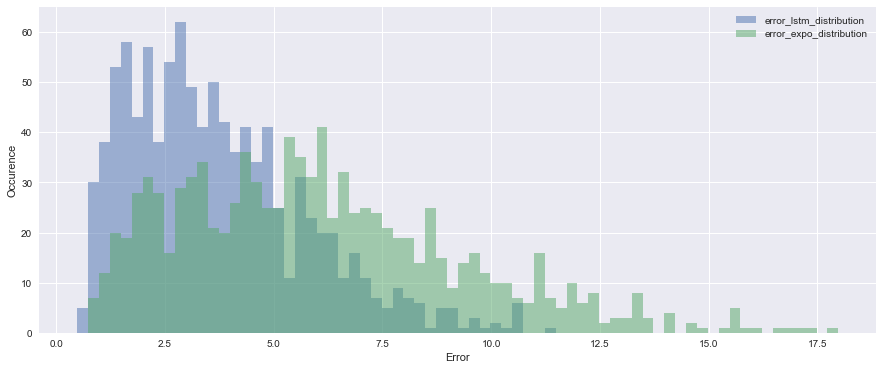

,error_lstm_distribution,error_expo_distribution
count,1000.000000,1000.000000
mean,3.686080,6.040087
std,2.037005,3.250778
min,0.485445,0.800078
25%,2.077396,3.465944
50%,3.301242,5.633689
75%,4.836360,7.927961
max,11.257191,17.980029


In [79]:
plt.style.use('seaborn')
df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])



df_testRest.plot.hist(alpha = 0.5, bins=70,figsize=(15,6))
plt.xlabel('Error')
plt.ylabel('Occurence')
plt.legend()
plt.show()

df_testRest.describe()

# True test

In [80]:
with gzip.open('data\\2017.11.01\\feeddata_11.json.gz', "rb") as f:
    data = json.loads(f.read().decode("ascii"))
WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)

local variable 'oldTime' referenced before assignment


In [84]:

def showOtherGraph_test_squared():
    startTime = np.random.randint(len(WaitingTimeAndTrade_test)-num_time_steps,size=())
    nbLabels = WaitingTimeAndTrade_test.shape[1]
    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model_Batched1")   
        X_new = np.array(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps, :].reshape(-1, num_time_steps, nbLabels))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    return np.average(np.square(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])) ,\
            np.average(np.square(returnPred_test(res_bench2.x,startTime) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0]))

In [85]:


error_lstm_dist_test = np.empty(shape = (0,0))
error_expo_dist_test = np.empty(shape = (0,0))
for i in range(0,1000):
    error_lstm, error_expo = showOtherGraph_test_squared()
    try:
        error_lstm_dist_test= np.append(error_lstm_dist_test,error_lstm)
        error_expo_dist_test = np.append(error_expo_dist_test,error_expo)
    except:
        pass

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

ValueError: operands could not be broadcast together with shapes (0,) (29,) 

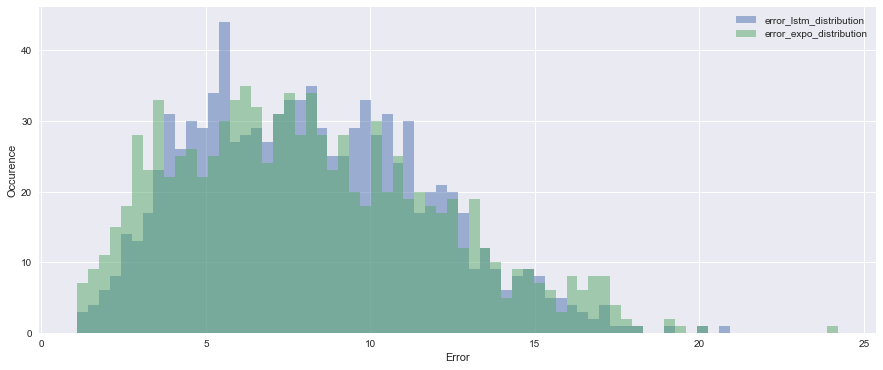

,error_lstm_distribution,error_expo_distribution
count,964.000000,964.000000
mean,8.208705,8.129951
std,3.532401,3.948623
min,1.181360,1.091750
25%,5.419204,5.102398
50%,7.966140,7.687119
75%,10.640994,10.829664
max,20.675510,24.221507


In [86]:
plt.style.use('seaborn')
df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist_test,error_expo_dist_test]), columns=['error_lstm_distribution', "error_expo_distribution"])



df_testRest.plot.hist(alpha = 0.5, bins=70,figsize=(15,6))
plt.xlabel('Error')
plt.ylabel('Occurence')
plt.legend()
plt.show()

df_testRest.describe()